#### Install PySpark, load required libraries and create spark session
---



In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     |████████████████████████████████| 281.3 MB 37 kB/s 
     |████████████████████████████████| 198 kB 43.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=7e0f941d757d792d5a72b1773ff10652cb96af2874ea29d3591929167e619186
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 37 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 143 MB of additional disk space will be used.
Selecting previously unselected package openjdk-8-jre-headless:amd64.
(Rea

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark import SparkContext, SparkConf

In [ ]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [ ]:
spark

In [ ]:
# Mount Google Drive to access datasets

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Introduction to Spark**

---



## What is Spark and why it is important

Spark is a platform for cluster computing (please do not confuse it with cloud computing).

Spark lets us distribute data and computations over clusters with multiple nodes (think of each node as a separate computer). 

Because of data and computations being split over multiple nodes, we can work with very large datasets as each node only works with a small amount of data.

As each node works on its own subset of the total data, so both data processing and computation are performed in parallel in the cluster.

Although this provides us with great computing power, it also increases the complexity.

To decide if we really need PySpark we need to think of the below points:
* Can my data fit in a single machine?
* Can my calculations be easily parallelized?

## Connection to Spark
The first step in using Spark is connecting to a cluster.

Most often, the cluster will be hosted on a remote machine (Cloud).

There will be one computer, called the master that manages splitting up the data and the computations. The master is connected to the rest of the computers in the cluster, which are called worker.

The first thing a Spark program must do is to create a `SparkContext` object, which tells Spark how to access a cluster. To create a `SparkContext` you first need to build a `SparkConf` object that contains information about your application.

Here's the [documentation](http://spark.apache.org/docs/2.1.0/api/python/pyspark.html) for all further details!

We have already created a SparkContext called sc earlier.


In [ ]:
# Verify SparkContext
print(sc)

# Print Spark version
print(sc.version)


<SparkContext master=local[*] appName=pyspark-shell>
3.2.0


## Spark DataFrames

Spark's core data structure is the Resilient Distributed Dataset (RDD) [Have you heard of something called parallelize in spark?]. This is a collection of elements partitioned across the nodes of the cluster that can be operated on in parallel. However, RDDs are hard to work with directly, so we use mostly use a Spark DataFrame abstraction built on top of RDDs.

The Spark DataFrame behaves a lot like Python DataFrame with variables in the columns and observations in the rows.

To start working with Spark DataFrames, we first have to create a `SparkSession` object from the `SparkContext`. Think of the `SparkContext` as our connection to the cluster and the `SparkSession` as our interface with that connection.

We have already created a `SparkSession` called `spark` earlier.

In [ ]:
print(spark)

## Lazy Evaluation
Spark works on the concept of lazy evaluation. What it means is that is does no real work unless encountered with an action.

Manipulations in the data like adding a new column, deleting a column etc are all transformations whereas statements such as `count`, `show` which forces spark to create the latest outputs are actions.

You may have hundreds of lines of codes with lots of transformations but spark will do no actual calculation unless it encounters an action.

## A small note on PySpark vs Spark

***Spark*** is a data computational framework that handles Big data. It is written in Scala but can also work well with other languages such as Java, Python, R.

***PySpark*** is a tool to support Python with Spark. It happens with the support of a library called Py4j, which is written in Python and gives a python interface to spark.



# **Reading data**
---

Most of the times our data will be hosted in cloud storage services like AWS S3, Azure storage or other SQL Database systems.

SparkSession has a .read attribute which has several methods for reading different data sources into Spark DataFrames. Using these you can create a DataFrame from a .csv file just like with regular pandas DataFrames!


## Reading CSV data

For this session we will work with [2015 Flight Delays and Cancellation](https://www.kaggle.com/usdot/flight-delays?select=flights.csv) data from kaggle

* YEAR - Year of the Flight Trip
* MONTH - Month of the Flight Trip
* DAY - Day of the Flight Trip
* DAY_OF_WEEK - Day of week of the Flight Trip
* AIRLINE - Airline Identifier
* FLIGHT_NUMBER - Flight Identifier
* TAIL_NUMBER - Aircraft Identifier
* ORIGIN_AIRPORT - Starting Airport
* DESTINATION_AIRPORT - Destination Airport
* SCHEDULED_DEPARTURE - Planned Departure Time
* DEPARTURE_TIME - WHEEL_OFF - TAXI_OUT
* DEPARTURE_DELAY - Total Delay on Departure
* TAXI_OUT - The time duration elapsed between departure from the origin airport gate and wheels off
* WHEELS_OFF - The time point that the aircraft's wheels leave the ground
* SCHEDULED_TIME - Planned time amount needed for the flight trip
* ELAPSED_TIME - AIR_TIME+TAXI_IN+TAXI_OUT
* AIR_TIME - The time duration between wheels_off and wheels_on time
* DISTANCE - Distance between two airports
* WHEELS_ON - The time point that the aircraft's wheels touch on the ground
* TAXI_IN - The time duration elapsed between wheels-on and gate arrival at the destination airport
* SCHEDULED_ARRIVAL - Planned arrival time
* ARRIVAL_TIME - WHEELS_ON+TAXI_IN
* ARRIVAL_DELAY - ARRIVAL_TIME-SCHEDULED_ARRIVAL
* DIVERTED - Aircraft landed on airport that out of schedule
* CANCELLED - Flight Cancelled (1 = cancelled)
* CANCELLATION_REASON - Reason for Cancellation of flight: A - Airline/Carrier; B - Weather; C - National Air System; D - Security
* AIR_SYSTEM_DELAY - Delay caused by air system
* SECURITY_DELAY - Delay caused by security
* AIRLINE_DELAY - Delay caused by the airline
* LATE_AIRCRAFT_DELAY - Delay caused by aircraft
* WEATHER_DELAY - Delay caused by weather


In [ ]:
dat_csv = spark.read.csv("/content/drive/My Drive/Colab Datasets/Kaggle_Flights_Data/flights.csv")
dat_csv.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: string (nullable = true)
 |-- _c9: string (nullable = true)
 |-- _c10: string (nullable = true)
 |-- _c11: string (nullable = true)
 |-- _c12: string (nullable = true)
 |-- _c13: string (nullable = true)
 |-- _c14: string (nullable = true)
 |-- _c15: string (nullable = true)
 |-- _c16: string (nullable = true)
 |-- _c17: string (nullable = true)
 |-- _c18: string (nullable = true)
 |-- _c19: string (nullable = true)
 |-- _c20: string (nullable = true)
 |-- _c21: string (nullable = true)
 |-- _c22: string (nullable = true)
 |-- _c23: string (nullable = true)
 |-- _c24: string (nullable = true)
 |-- _c25: string (nullable = true)
 |-- _c26: string (nullable = true)
 |-- _c27: string (nullable = tru

In [ ]:
import time

start_time = time.time()

dat_csv = spark.read.csv("/content/drive/My Drive/Colab Datasets/Kaggle_Flights_Data/flights.csv", inferSchema=True, header=True)
dat_csv.printSchema()

print(time.time()-start_time)

root
 |-- YEAR: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- FLIGHT_NUMBER: integer (nullable = true)
 |-- TAIL_NUMBER: string (nullable = true)
 |-- ORIGIN_AIRPORT: string (nullable = true)
 |-- DESTINATION_AIRPORT: string (nullable = true)
 |-- SCHEDULED_DEPARTURE: integer (nullable = true)
 |-- DEPARTURE_TIME: integer (nullable = true)
 |-- DEPARTURE_DELAY: integer (nullable = true)
 |-- TAXI_OUT: integer (nullable = true)
 |-- WHEELS_OFF: integer (nullable = true)
 |-- SCHEDULED_TIME: integer (nullable = true)
 |-- ELAPSED_TIME: integer (nullable = true)
 |-- AIR_TIME: integer (nullable = true)
 |-- DISTANCE: integer (nullable = true)
 |-- WHEELS_ON: integer (nullable = true)
 |-- TAXI_IN: integer (nullable = true)
 |-- SCHEDULED_ARRIVAL: integer (nullable = true)
 |-- ARRIVAL_TIME: integer (nullable = true)
 |-- ARRIVAL_DELAY: integer (null

In [ ]:
print('# Rows: ', dat_csv.count())
print('# Columns: ', len(dat_csv.columns))
dat_csv.show(5)

# Rows:  5819079
# Columns:  31
+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TAXI_IN|SCHEDULED_ARRIVAL|ARRIVAL_TIME|ARRIVAL_DELAY|DIVERTED|CANCELLED|CANCELLATION_REASON|AIR_SYSTEM_DELAY|SECURITY_DELAY|AIRLINE_DELAY|LATE_AIRCRAFT_DELAY|WEATHER_DELAY|
+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+------

To Understand any data we do load the data and go through it, but insights from business and definitions for various columns is one of the most critical input

#### Issues with CSV
* You either need a prior knowledge of schema or need to use `inferSchema`
* This time we only had 5000 rows but when dealing with millions and billions of rows, it can increase loading time
* Issue in data types. Some of the datatypes could be assigned incorrectly. Even if we use user defined schema, there will be chances of data mismatch from the source
* header could be missing from the file


## Dealing with Parquet files

* Parquet stores data in folders and partitions
* Data is compressed so requires less storage
* Schema information is inbuilt so it does not need to read the data to identify the schema
* it follows columnar storage which offers huge optimization when we need only few required columns. Remember, spark follows lazy optimization and it will internally optimize by reading required columns when provided with Parquet files
* Partitioning of data on specific features helps in loading only the required amount of data
* One large file works worse than many small files when dealing with spark as import jobs will not be assigned to available workers

In [ ]:
start_time = time.time()
flights = spark.read.parquet('/content/drive/My Drive/Colab Datasets/Flights_Data_Parquet')
flights.printSchema()
print(time.time()-start_time)

root
 |-- YEAR: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- FLIGHT_NUMBER: integer (nullable = true)
 |-- TAIL_NUMBER: string (nullable = true)
 |-- ORIGIN_AIRPORT: string (nullable = true)
 |-- DESTINATION_AIRPORT: string (nullable = true)
 |-- SCHEDULED_DEPARTURE: integer (nullable = true)
 |-- DEPARTURE_TIME: integer (nullable = true)
 |-- DEPARTURE_DELAY: integer (nullable = true)
 |-- TAXI_OUT: integer (nullable = true)
 |-- WHEELS_OFF: integer (nullable = true)
 |-- SCHEDULED_TIME: integer (nullable = true)
 |-- ELAPSED_TIME: integer (nullable = true)
 |-- AIR_TIME: integer (nullable = true)
 |-- DISTANCE: integer (nullable = true)
 |-- WHEELS_ON: integer (nullable = true)
 |-- TAXI_IN: integer (nullable = true)
 |-- SCHEDULED_ARRIVAL: integer (nullable = true)
 |-- ARRIVAL_TIME: integer (nullable = true)
 |-- ARRIVAL_DELAY: integer (null

In [ ]:
start_time = time.time()
print('# Rows: ', flights.count())
print('# Columns: ', len(flights.columns))
flights.show(5)
print(time.time()-start_time)

# Rows:  5819079
# Columns:  31
+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TAXI_IN|SCHEDULED_ARRIVAL|ARRIVAL_TIME|ARRIVAL_DELAY|DIVERTED|CANCELLED|CANCELLATION_REASON|AIR_SYSTEM_DELAY|SECURITY_DELAY|AIRLINE_DELAY|LATE_AIRCRAFT_DELAY|WEATHER_DELAY|
+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+------

# **Data Manipulation**
---

We will now look at the methods defined by Spark's *`DataFrame`* class to perform common data operations.

Modeling on a data is not the only task of a data scientist.

A huge amont of time goes into transforming datasets to create insightful reports.

## Creating columns

Performing column-wise operations in Spark can be done using the `.withColumn()` method, which takes two arguments. First, a string with the name of your new column, and second the new column itself.

The new column must be an object of class *Column*. Just think of this as a dataframe with only one column.

Updating a Spark DataFrame is somewhat different than working in *pandas* because the Spark DataFrame is *immutable*. This means that it can't be changed, and so columns can't be updated in place.

Thus, all these methods return a new DataFrame. To overwrite the original DataFrame we just reassign the returned DataFrame.

To overwrite an existing column, just pass the name of the column as the first argument.


In [ ]:
# Update flights to include a new column called DURATION_HRS
flights = flights.withColumn("DURATION_HRS",flights.AIR_TIME/60)
flights.show(10)

+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+------------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TAXI_IN|SCHEDULED_ARRIVAL|ARRIVAL_TIME|ARRIVAL_DELAY|DIVERTED|CANCELLED|CANCELLATION_REASON|AIR_SYSTEM_DELAY|SECURITY_DELAY|AIRLINE_DELAY|LATE_AIRCRAFT_DELAY|WEATHER_DELAY|      DURATION_HRS|
+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+

## Filtering Data
The `.filter()` method in spark is very similar to `WHERE` clause in SQL. It takes either an SQL like expression or a Spark Column of boolean (True/False) values.



In [ ]:
# Filter flights by passing a string
filter1 = flights.filter("DISTANCE>1000")

# Filter flights by passing a column of boolean values
filter2 = flights.filter(flights.DISTANCE>1000)

# Print the data to check they're equal
filter1.show(5)
filter2.show(5)


+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+------------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TAXI_IN|SCHEDULED_ARRIVAL|ARRIVAL_TIME|ARRIVAL_DELAY|DIVERTED|CANCELLED|CANCELLATION_REASON|AIR_SYSTEM_DELAY|SECURITY_DELAY|AIRLINE_DELAY|LATE_AIRCRAFT_DELAY|WEATHER_DELAY|      DURATION_HRS|
+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+

In [ ]:
# Another way to filter data

# Create the boolean columns seperately and then pass them in filter
filterA = flights.ORIGIN_AIRPORT == "SEA"
filterB = flights.DESTINATION_AIRPORT == "JFK"

# Filter the data, first by filterA then by filterB
flights.filter(filterA).filter(filterB).show(5)

+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TAXI_IN|SCHEDULED_ARRIVAL|ARRIVAL_TIME|ARRIVAL_DELAY|DIVERTED|CANCELLED|CANCELLATION_REASON|AIR_SYSTEM_DELAY|SECURITY_DELAY|AIRLINE_DELAY|LATE_AIRCRAFT_DELAY|WEATHER_DELAY|DURATION_HRS|
+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+------------

## Selecting Required Columns
The `.select()` method is used whe we have to select certain required columns from the Dataframe. Arguments to this method can either be the column name as a string or a column object.


In [ ]:
# Using column names as string
select1 = flights.select("TAIL_NUMBER","ORIGIN_AIRPORT","DESTINATION_AIRPORT")

# Using column object
select2 = flights.select(flights.TAIL_NUMBER, flights.ORIGIN_AIRPORT, flights.DESTINATION_AIRPORT)

select1.show(5)
select2.show(5)

+-----------+--------------+-------------------+
|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|
+-----------+--------------+-------------------+
|     N742SW|           SFO|                DEN|
|     N486WN|           BOS|                BWI|
|     N293WN|           LAS|                BWI|
|     N249WN|           ABQ|                HOU|
|     N630WN|           PHX|                SLC|
+-----------+--------------+-------------------+
only showing top 5 rows

+-----------+--------------+-------------------+
|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|
+-----------+--------------+-------------------+
|     N742SW|           SFO|                DEN|
|     N486WN|           BOS|                BWI|
|     N293WN|           LAS|                BWI|
|     N249WN|           ABQ|                HOU|
|     N630WN|           PHX|                SLC|
+-----------+--------------+-------------------+
only showing top 5 rows



When you pass a column object, you can perform operations like addition or subtraction on the column to change the data contained in it, much like `.withColumn()`.

The difference between `.select()` and `.withColumn()` methods is that `.select()` returns only the columns you specify, while `.withColumn()` returns all the columns of the DataFrame in addition to the one you defined. 

It's often a good idea to select only the columns you need at the beginning of an operation.

In [ ]:
# Performing column operation when selecting columns
flights.select(flights.ORIGIN_AIRPORT, flights.DESTINATION_AIRPORT, flights.AIR_TIME/60).show(5)

+--------------+-------------------+------------------+
|ORIGIN_AIRPORT|DESTINATION_AIRPORT|   (AIR_TIME / 60)|
+--------------+-------------------+------------------+
|           SFO|                DEN|               2.2|
|           BOS|                BWI|              1.05|
|           LAS|                BWI|3.8333333333333335|
|           ABQ|                HOU|1.7166666666666666|
|           PHX|                SLC|1.2666666666666666|
+--------------+-------------------+------------------+
only showing top 5 rows



In [ ]:
# Mix and select
flights.select('ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', flights.AIR_TIME/60).show(5)

+--------------+-------------------+------------------+
|ORIGIN_AIRPORT|DESTINATION_AIRPORT|   (AIR_TIME / 60)|
+--------------+-------------------+------------------+
|           SFO|                DEN|               2.2|
|           BOS|                BWI|              1.05|
|           LAS|                BWI|3.8333333333333335|
|           ABQ|                HOU|1.7166666666666666|
|           PHX|                SLC|1.2666666666666666|
+--------------+-------------------+------------------+
only showing top 5 rows



In [ ]:
# Renaming columns when selecting
flights.select('ORIGIN_AIRPORT', flights.DESTINATION_AIRPORT.alias("DEST"), (flights.AIR_TIME/60).alias("DURATION_HRS")).show(5)

# Note: .alias() works on column objects

+--------------+----+------------------+
|ORIGIN_AIRPORT|DEST|      DURATION_HRS|
+--------------+----+------------------+
|           SFO| DEN|               2.2|
|           BOS| BWI|              1.05|
|           LAS| BWI|3.8333333333333335|
|           ABQ| HOU|1.7166666666666666|
|           PHX| SLC|1.2666666666666666|
+--------------+----+------------------+
only showing top 5 rows



To use SQL like strings, use `selectExpr`


In [ ]:
# Define avg_speed
avg_speed = (flights.DISTANCE/(flights.AIR_TIME/60)).alias("AVG_SPEED")

# Select the correct columns
speed1 = flights.select("ORIGIN_AIRPORT", "DESTINATION_AIRPORT", avg_speed)

# Create the same table using a SQL expression
speed2 = flights.selectExpr("ORIGIN_AIRPORT", "DESTINATION_AIRPORT", "DISTANCE/(AIR_TIME/60) as AVG_SPEED")

speed1.show(5)
speed2.show(5)

+--------------+-------------------+-----------------+
|ORIGIN_AIRPORT|DESTINATION_AIRPORT|        AVG_SPEED|
+--------------+-------------------+-----------------+
|           SFO|                DEN|439.5454545454545|
|           BOS|                BWI|351.4285714285714|
|           LAS|                BWI|549.3913043478261|
|           ABQ|                HOU|442.1359223300971|
|           PHX|                SLC|400.2631578947369|
+--------------+-------------------+-----------------+
only showing top 5 rows

+--------------+-------------------+-----------------+
|ORIGIN_AIRPORT|DESTINATION_AIRPORT|        AVG_SPEED|
+--------------+-------------------+-----------------+
|           SFO|                DEN|439.5454545454545|
|           BOS|                BWI|351.4285714285714|
|           LAS|                BWI|549.3913043478261|
|           ABQ|                HOU|442.1359223300971|
|           PHX|                SLC|400.2631578947369|
+--------------+-------------------+----

In [ ]:
# Selecting columns by subsetting from list of available columns
flights.select(flights.columns[:8]).show(2)

# This can be helpful when we have joined multiple datasets and want do select only a few initial columns

+----+-----+---+-----------+-------+-------------+-----------+--------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|
+----+-----+---+-----------+-------+-------------+-----------+--------------+
|2015|    1|  1|          4|     WN|          526|     N742SW|           SFO|
|2015|    1|  1|          4|     WN|         4122|     N486WN|           BOS|
+----+-----+---+-----------+-------+-------------+-----------+--------------+
only showing top 2 rows



## Dropping Columns

If suppose we have many columns and we want to delete some of them then we can do so by sing `.drop()`

In [ ]:
# dropping a column by passing column names
drop1 = flights.drop('WEATHER_DELAY', 'LATE_AIRCRAFT_DELAY')

# dropping columns by passing a list
columns = ['WEATHER_DELAY', 'LATE_AIRCRAFT_DELAY']
drop2 = flights.drop(*columns)
# will this work if we remove * from before columns?
# can we do a similar thing to select columns for this dataframe? 
# this can be helpful if we have to try different features when modeling

flights.show(2)
drop1.show(2)
drop2.show(2)


+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TAXI_IN|SCHEDULED_ARRIVAL|ARRIVAL_TIME|ARRIVAL_DELAY|DIVERTED|CANCELLED|CANCELLATION_REASON|AIR_SYSTEM_DELAY|SECURITY_DELAY|AIRLINE_DELAY|LATE_AIRCRAFT_DELAY|WEATHER_DELAY|DURATION_HRS|
+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+------------

## Grouping and Aggregating data

All of the common aggregation methods, like `.min()`, `.max()`, and `.count()` are `GroupedData` methods on certain columns, created by calling the `.groupBy()` method.

PySpark has a whole class devoted to grouped data frames: `pyspark.sql.GroupedData`

In [ ]:
# Find the Minimum time in Taxi from JFK
flights.filter(flights.ORIGIN_AIRPORT=="JFK").groupBy().min("TAXI_OUT").show()

# Find the Maximum time in Taxi from JFK
flights.filter(flights.ORIGIN_AIRPORT=="JFK").groupBy().max("TAXI_OUT").show()

# Find the Average time in Taxi from JFK
flights.filter(flights.ORIGIN_AIRPORT=="JFK").groupBy().avg("TAXI_OUT").show()


+-------------+
|min(TAXI_OUT)|
+-------------+
|            3|
+-------------+

+-------------+
|max(TAXI_OUT)|
+-------------+
|          180|
+-------------+

+------------------+
|     avg(TAXI_OUT)|
+------------------+
|27.009783223784442|
+------------------+



We have seen how to create a grouped DataFrame by calling the `.groupBy()` method on a DataFrame with no arguments. Now lets try passing some column names to it.


In [ ]:
# Group by AIRLINE
flights.groupBy('ORIGIN_AIRPORT').avg("TAXI_OUT").show(10)

# lets try to sort this based on average time
# we already have pyspark.sql.functions imported as F
flights.groupBy('ORIGIN_AIRPORT').avg("TAXI_OUT").sort(F.desc('avg(TAXI_OUT)')).show(10)

+--------------+------------------+
|ORIGIN_AIRPORT|     avg(TAXI_OUT)|
+--------------+------------------+
|           BGM|15.818532818532818|
|           INL|19.113274336283187|
|         12888|13.538461538461538|
|           MSY|10.976116059801011|
|         12003|14.626315789473685|
|         15041|               8.7|
|           GEG|13.923337210531882|
|           BUR|12.008937224076666|
|           SNA|12.221841797777234|
|           GRB|13.468399915451279|
+--------------+------------------+
only showing top 10 rows

+--------------+------------------+
|ORIGIN_AIRPORT|     avg(TAXI_OUT)|
+--------------+------------------+
|           JFK|27.009783223784442|
|           LGA|26.721369750638914|
|         12953|26.660011813349083|
|         12478|23.677466150870405|
|         13502|23.666666666666668|
|           ITH|22.533333333333335|
|           PHL|21.709365521700974|
|           ISN| 20.99641862315957|
|         12389|20.509090909090908|
|           EWR|  20.1907141264468|
+-

In addition to the GroupedData methods, there is also the .agg() method. This method lets you pass an aggregate column expression that uses any of the aggregate functions from the pyspark.sql.functions submodule.

This submodule contains many useful functions for computing things like standard deviations. All the aggregation functions in this submodule take the name of a column in a GroupedData table.


In [ ]:
# Import pyspark.sql.functions as F

# Group by ORIGIN_AIRPORT
orig_air = flights.groupBy("ORIGIN_AIRPORT")

# Average time in Taxi
orig_air.avg("TAXI_OUT").sort(F.desc('avg(TAXI_OUT)')).show(10)

# Standard deviation of Taxi
orig_air.agg(F.stddev("TAXI_OUT")).sort(F.desc('stddev_samp(TAXI_OUT)')).show(10)

+--------------+------------------+
|ORIGIN_AIRPORT|     avg(TAXI_OUT)|
+--------------+------------------+
|           JFK|27.009783223784442|
|           LGA|26.721369750638914|
|         12953|26.660011813349083|
|         12478|23.677466150870405|
|         13502|23.666666666666668|
|           ITH|22.533333333333335|
|           PHL|21.709365521700974|
|           ISN| 20.99641862315957|
|         12389|20.509090909090908|
|           EWR|  20.1907141264468|
+--------------+------------------+
only showing top 10 rows

+--------------+---------------------+
|ORIGIN_AIRPORT|stddev_samp(TAXI_OUT)|
+--------------+---------------------+
|           MMH|    16.05318754706919|
|         15497|   14.627987625713319|
|           LGA|    14.44829164624525|
|         12953|   14.311777482769433|
|           JFK|   13.649207254602993|
|           BRD|   13.364328796110769|
|           PHL|   13.282167044588624|
|         11537|   13.259437708386624|
|         10577|   13.191757838931677|
| 

## Renaming a column
We dont really like to see names like `stddev_samp(TAXI_OUT)` in our dataframes, so lets try to change it something better

In [ ]:
new_df = orig_air.agg(F.stddev("TAXI_OUT"))

new_df.show(2)

new_df = new_df.withColumnRenamed('stddev_samp(TAXI_OUT)', 'STD_DEV_TAXI_OUT')

new_df.show(2)

+--------------+---------------------+
|ORIGIN_AIRPORT|stddev_samp(TAXI_OUT)|
+--------------+---------------------+
|           BGM|   10.418095289780277|
|           INL|    9.711142832374387|
+--------------+---------------------+
only showing top 2 rows

+--------------+------------------+
|ORIGIN_AIRPORT|  STD_DEV_TAXI_OUT|
+--------------+------------------+
|           BGM|10.418095289780277|
|           INL| 9.711142832374387|
+--------------+------------------+
only showing top 2 rows



## Joining Multiple Dataframes

Most of the times our fact data will have codes instead of actual names similar to the airport codes we have in our data. In order to gain proper insights, we have *join* these dataframes with reference dataframes

In PySpark, joins are performed using the DataFrame method `.join()`. 

This method takes three arguments:
* The first argument is the second DataFrame that you want to join with the first one.
* The second argument, `on`, is the name of the key column(s) as a string. ***The names of the key column(s) must be the same in each table***.
* The third argument, `how`, specifies the kind of join to perform.


In [ ]:
# Load the airports dataset
airports = spark.read.csv('/content/drive/My Drive/Colab Datasets/Kaggle_Flights_Data/airports.csv', inferSchema=True, header=True)

# Examine the data
airports.show(5)


+---------+--------------------+-----------+-----+-------+--------+----------+
|IATA_CODE|             AIRPORT|       CITY|STATE|COUNTRY|LATITUDE| LONGITUDE|
+---------+--------------------+-----------+-----+-------+--------+----------+
|      ABE|Lehigh Valley Int...|  Allentown|   PA|    USA|40.65236|  -75.4404|
|      ABI|Abilene Regional ...|    Abilene|   TX|    USA|32.41132|  -99.6819|
|      ABQ|Albuquerque Inter...|Albuquerque|   NM|    USA|35.04022|-106.60919|
|      ABR|Aberdeen Regional...|   Aberdeen|   SD|    USA|45.44906| -98.42183|
|      ABY|Southwest Georgia...|     Albany|   GA|    USA|31.53552| -84.19447|
+---------+--------------------+-----------+-----+-------+--------+----------+
only showing top 5 rows



In [ ]:
# Rename the airport code column
airports1 = airports.withColumnRenamed("IATA_CODE", "ORIGIN_AIRPORT")

# Join the DataFrames
flights_with_airports = flights.join(airports1, on="ORIGIN_AIRPORT",how="leftouter")

# Examine the new DataFrame
flights_with_airports.show(5)

# Perform grouping on Airport Name
flights_with_airports.groupBy('AIRPORT').avg("TAXI_OUT").sort(F.desc('avg(TAXI_OUT)')).show(10, truncate=0)

+--------------+----+-----+---+-----------+-------+-------------+-----------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+------------------+--------------------+-------------+-----+-------+--------+----------+
|ORIGIN_AIRPORT|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TAXI_IN|SCHEDULED_ARRIVAL|ARRIVAL_TIME|ARRIVAL_DELAY|DIVERTED|CANCELLED|CANCELLATION_REASON|AIR_SYSTEM_DELAY|SECURITY_DELAY|AIRLINE_DELAY|LATE_AIRCRAFT_DELAY|WEATHER_DELAY|      DURATION_HRS|             AIRPORT|         CITY|STATE|COUNTRY|LATITUDE| LONGITUDE|
+--------------+----+-----+---

## Using broadcasting on Spark joins
Remember that table joins in Spark are split between the cluster workers. If the data is not local, various shuffle operations are required and can have a negative impact on performance. Instead, we're going to use Spark's broadcast operations to give each node a copy of the specified data.

A couple tips:

Broadcast the smaller DataFrame. The larger the DataFrame, the more time required to transfer to the worker nodes.

If we dont have small DataFrames, it may be better skip broadcasting and let Spark figure out any optimization on its own.

If you look at the query execution plan, a broadcastHashJoin indicates you've successfully configured broadcasting.


In [ ]:
# Import the broadcast method from pyspark.sql.functions
from pyspark.sql.functions import broadcast

# Join the flights_df and airports_df DataFrames using broadcasting
broadcast_df = flights.join(broadcast(airports), \
    flights["DESTINATION_AIRPORT"] == airports["IATA_CODE"] )

# Show the query plan and compare against the original
broadcast_df.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- BroadcastHashJoin [DESTINATION_AIRPORT#356], [IATA_CODE#2424], Inner, BuildRight, false
   :- Project [YEAR#348, MONTH#349, DAY#350, DAY_OF_WEEK#351, AIRLINE#352, FLIGHT_NUMBER#353, TAIL_NUMBER#354, ORIGIN_AIRPORT#355, DESTINATION_AIRPORT#356, SCHEDULED_DEPARTURE#357, DEPARTURE_TIME#358, DEPARTURE_DELAY#359, TAXI_OUT#360, WHEELS_OFF#361, SCHEDULED_TIME#362, ELAPSED_TIME#363, AIR_TIME#364, DISTANCE#365, WHEELS_ON#366, TAXI_IN#367, SCHEDULED_ARRIVAL#368, ARRIVAL_TIME#369, ARRIVAL_DELAY#370, DIVERTED#371, ... 8 more fields]
   :  +- Filter isnotnull(DESTINATION_AIRPORT#356)
   :     +- FileScan parquet [YEAR#348,MONTH#349,DAY#350,DAY_OF_WEEK#351,AIRLINE#352,FLIGHT_NUMBER#353,TAIL_NUMBER#354,ORIGIN_AIRPORT#355,DESTINATION_AIRPORT#356,SCHEDULED_DEPARTURE#357,DEPARTURE_TIME#358,DEPARTURE_DELAY#359,TAXI_OUT#360,WHEELS_OFF#361,SCHEDULED_TIME#362,ELAPSED_TIME#363,AIR_TIME#364,DISTANCE#365,WHEELS_ON#366,TAXI_IN#367,SCHEDULED_ARRIVAL#368,

#### Comparing broadcast vs normal joins
We have created two types of joins, normal and broadcasted. Now we would like to know what the performance improvement is by using Spark optimizations. 

Looking at the below doesn't seem to be any major improvement but that is because we are running in a local machine without any actual master worker setup.

In [ ]:
start_time = time.time()
# Count the number of rows in the normal DataFrame
normal_count = flights_with_airports.count()
normal_duration = time.time() - start_time

start_time = time.time()
# Count the number of rows in the broadcast DataFrame
broadcast_count = broadcast_df.count()
broadcast_duration = time.time() - start_time

# Print the counts and the duration of the tests
print("Normal count:\t\t%d\tduration: %f" % (normal_count, normal_duration))
print("Broadcast count:\t%d\tduration: %f" % (broadcast_count, broadcast_duration))

Normal count:		5819079	duration: 1.526359
Broadcast count:	5332914	duration: 1.612185


#### Checking for Bad Joins

We need to be very careful when working with the joins. Often incorrect joins will not give any error but the output will be very different from expected.

* **One to many joins** - when performing left join, if our right table has duplications in join key column then this can result in number of rows being higher then original dataframe. *It is one of the most common mistake when joining multiple tables!*
* **many to many joins** - another common issue when joining tables is when both left and right tables have duplications in joining keys. This results in # rows being multipled by the number of duplicated rows in both left and right table
* **Selecting proper left or right table when performing left or right join** - remember, when performing a left join, the table which you want to retain in its entirety goes as first table and the second table goes inside the bracket. Similarly for right join.

careful when joining over decimal values. If the precision level is diffrent between the tables then it can lead to duplication in rows.

## Dropping Duplicate rows


In [ ]:
# distinct will de dup the dataframe by taking all the columns into consideration
print(airports.distinct().count())

# we can pass a subset of columns in dropDuplicates which needs to be considered for de duplicating the Dataframe
print(airports.dropDuplicates(['STATE']).count())


322
54


## Summary statistics 
we can create summary statistics for required or all columns of a dataframe using the `.describe()` method

Note: Summary statistics is provided for numeric data only

In [ ]:
flights.select('TAXI_OUT','TAXI_IN').describe().show()

+-------+-----------------+------------------+
|summary|         TAXI_OUT|           TAXI_IN|
+-------+-----------------+------------------+
|  count|          5730032|           5726566|
|   mean|16.07166225249702|7.4349708010001105|
| stddev|8.895574065449965| 5.638547687322167|
|    min|                1|                 1|
|    max|              225|               248|
+-------+-----------------+------------------+



In [ ]:
flights.describe(['TAXI_OUT','TAXI_IN','AIRLINE']).show()

+-------+-----------------+------------------+-------+
|summary|         TAXI_OUT|           TAXI_IN|AIRLINE|
+-------+-----------------+------------------+-------+
|  count|          5730032|           5726566|5819079|
|   mean|16.07166225249702|7.4349708010001105|   null|
| stddev|8.895574065449965| 5.638547687322167|   null|
|    min|                1|                 1|     AA|
|    max|              225|               248|     WN|
+-------+-----------------+------------------+-------+



# **Running SQL queries in PySpark**
---


## Creating SQL tables

One of the advantages of the DataFrame interface is that we can run SQL queries on the tables in the Spark cluster. However, we cannot do so directly on the spark Dataframe but need to create a temporary table on top of the Spark Dataframe.

Using SQL in PySpark makes the program concise, easy to understand and *portable* (example if you have to move from AWS Glue to Athena, it can be easily done)


In [ ]:
flights.createOrReplaceTempView('flights')

## List tables in catalog
Your `SparkSession` has an attribute called `catalog` which lists all the data inside the cluster. This attribute has a few methods for extracting different pieces of information, and one of the most useful is the `.listTables()` method, which returns the names of all the tables in the cluster as a `list`.


In [ ]:
# Print the tables in the catalog
print(spark.catalog.listTables())


[Table(name='flights', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]


## Running SQL queries

To run a query on this table, all we need to do is pass the sql query as a string to the `sql()` method in the `SparkSession`. This method takes a string containing the query and returns a DataFrame with the results.

A good command over SQL is a must in data science industry and if you are not already familier with it, practising them on the PySpark can be helpful.

In [ ]:
sql_query = "FROM flights SELECT * LIMIT 10"

# Get the first 10 rows
dat10 = spark.sql(sql_query)

# Show the results
dat10.show()

+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+------------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TAXI_IN|SCHEDULED_ARRIVAL|ARRIVAL_TIME|ARRIVAL_DELAY|DIVERTED|CANCELLED|CANCELLATION_REASON|AIR_SYSTEM_DELAY|SECURITY_DELAY|AIRLINE_DELAY|LATE_AIRCRAFT_DELAY|WEATHER_DELAY|      DURATION_HRS|
+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+

## Spark SQL Join
Sometimes it is much easier to write complex joins in SQL. 


In [ ]:
# Register airports tables
airports.createOrReplaceTempView('airports')

# SQL to join dataframes
join_sql = 	"""
			SELECT 
				AIRPORT, avg(TAXI_OUT) as AVG_TAXI_OUT
			FROM flights
			LEFT JOIN airports
			ON flights.ORIGIN_AIRPORT = airports.IATA_CODE
      GROUP BY AIRPORT
      ORDER BY AVG_TAXI_OUT desc
			"""

# Perform sql join
joined_df = spark.sql(join_sql)

joined_df.show(10, truncate=False)

+----------------------------------------------------------------------+------------------+
|AIRPORT                                                               |AVG_TAXI_OUT      |
+----------------------------------------------------------------------+------------------+
|John F. Kennedy International Airport (New York International Airport)|27.009783223784442|
|LaGuardia Airport (Marine Air Terminal)                               |26.721369750638914|
|Ithaca Tompkins Regional Airport                                      |22.533333333333335|
|Philadelphia International Airport                                    |21.709365521700974|
|Sloulin Field International Airport                                   |20.99641862315957 |
|Newark Liberty International Airport                                  |20.1907141264468  |
|Gen. Edward Lawrence Logan International Airport                      |20.019864843029723|
|Charlotte Douglas International Airport                               |19.65315

## Convert a Spark DataFrame to Pandas DataFrame

Suppose you've run a query on your huge dataset and aggregated it down to something a little more manageable.

Sometimes it makes sense to then take that table and work with it locally using a tool like pandas. Spark DataFrames make that easy with the .toPandas() method. Calling this method on a Spark DataFrame returns the corresponding pandas DataFrame.

We will see more applications of this later

In [ ]:
pd_dat = spark.sql("""SELECT AIRLINE, COUNT(*) as Num_Flights
                      FROM flights
                      GROUP BY 1 ORDER BY 2 DESC""").toPandas()

pd_dat.head()

,AIRLINE,Num_Flights
0,WN,1261855
1,DL,875881
2,AA,725984
3,OO,588353
4,EV,571977


## Pandas to Spark DataFrame

We just saw how to move data from Spark to pandas. However, maybe you want to go the other direction, and put a pandas DataFrame into a Spark cluster. The SparkSession class has a method for this as well.

The .createDataFrame() method takes a pandas DataFrame and returns a Spark DataFrame.

In [ ]:
# Create pd_temp as a collection of random numbers
pd_temp = pd.DataFrame(np.random.random(10))

# Create spark_temp from pd_temp
spark_temp = spark.createDataFrame(pd_temp)

# Examine the tables in the catalog
print(spark.catalog.listTables())

# Add spark_temp to the catalog
spark_temp.createOrReplaceTempView("temp")

# Examine the tables in the catalog again
print(spark.catalog.listTables())

[Table(name='airports', database=None, description=None, tableType='TEMPORARY', isTemporary=True), Table(name='flights', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]
[Table(name='airports', database=None, description=None, tableType='TEMPORARY', isTemporary=True), Table(name='flights', database=None, description=None, tableType='TEMPORARY', isTemporary=True), Table(name='temp', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]


In [ ]:
# Dropping a temporary table
spark.catalog.dropTempView('temp')
print(spark.catalog.listTables())

[Table(name='airports', database=None, description=None, tableType='TEMPORARY', isTemporary=True), Table(name='flights', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]


# Cleaning Data with PySpark
---

Let us import another dataset with larger number of columns and more variable data. We will utiliize our knowledge from previous section to prepare this dataset for any real output.

In [ ]:
real_estate_df = spark.read.parquet('/content/drive/My Drive/Colab Datasets/Real_Estate_Data_Parquet')
real_estate_df.show(5)

+----+-----+-------------------+--------------------+----------+----------+---------------+----------------+---------------+----------+---------+---------------+-----------------+------------+--------------+-----+---------+--------------------+--------------------+------------+-------------+----------+---------+--------------------+--------------------+----------+------------------+--------------------+----+--------------------+---------------+-----+----------+---------+------------------+-------+----------+----------+---------+--------------------+--------------------+-----+------------------+--------------------+----------------+--------------+---------+------------+----------+----------+---------+---------------------+--------------------+---------+---------+-----------+-----------------+-----+----------+--------------------+---------+----------+---------+----------+---------+----------+---------+----------+--------+---------------+-----------------+--------------+-----------------+

## Dropping a list of columns
Our data set is rich with a lot of features, but not all are valuable. For now, let's remove any columns that aren't immediately useful by dropping them.

'STREETNUMBERNUMERIC': The postal address number on the home
'FIREPLACES': Number of Fireplaces in the home
'LOTSIZEDIMENSIONS': Free text describing the lot shape
'LISTTYPE': Set list of values of sale type
'ACRES': Numeric area of lot size


In [ ]:
# List of columns to remove from dataset
cols_to_drop = ['STREETNUMBERNUMERIC', 'FIREPLACES','LOTSIZEDIMENSIONS','LISTTYPE','ACRES']

# Drop columns in list
real_estate_df = real_estate_df.drop(*cols_to_drop)

real_estate_df.show(2)

+----+-----+--------------------+----------+----------+---------------+----------------+---------------+----------+---------+-----------------+------------+--------------+-----+---------+--------------------+------------+-------------+---------+--------------------+--------------------+----------+------------------+---------------+----+--------------------+---------------+-----+----------+---------+------------------+-------+----------+----------+---------+--------------------+--------------------+------------------+--------------------+----------------+--------------+---------+------------+----------+----------+---------+---------------------+--------------------+---------+---------+-----------+-----------------+-----+----------+--------------------+---------+----------+---------+----------+---------+----------+---------+----------+--------+---------------+-----------------+--------------+-----------------+-----------------+
| No.|MLSID|       streetaddress|STREETNAME|PostalCode|State

## Renaming columns

Sometimes it pays to have renamed the column names to something more insightful. Here, we will rename the `'No.'` columns so that it is easier to work with

In [ ]:
real_estate_df = real_estate_df.withColumnRenamed('No.','Listing_Numbers')
real_estate_df.columns

['Listing_Numbers',
 'MLSID',
 'streetaddress',
 'STREETNAME',
 'PostalCode',
 'StateOrProvince',
 'City',
 'SalesClosePrice',
 'LISTDATE',
 'LISTPRICE',
 'OriginalListPrice',
 'PricePerTSFT',
 'FOUNDATIONSIZE',
 'FENCE',
 'MapLetter',
 'SchoolDistrictNumber',
 'DAYSONMARKET',
 'offmarketdate',
 'RoomArea4',
 'roomtype',
 'ROOF',
 'RoomFloor4',
 'PotentialShortSale',
 'PoolDescription',
 'PDOM',
 'GarageDescription',
 'SQFTABOVEGROUND',
 'Taxes',
 'RoomFloor1',
 'RoomArea1',
 'TAXWITHASSESSMENTS',
 'TAXYEAR',
 'LivingArea',
 'UNITNUMBER',
 'YEARBUILT',
 'ZONING',
 'STYLE',
 'CoolingDescription',
 'APPLIANCES',
 'backonmarketdate',
 'ROOMFAMILYCHAR',
 'RoomArea3',
 'EXTERIOR',
 'RoomFloor3',
 'RoomFloor2',
 'RoomArea2',
 'DiningRoomDescription',
 'BASEMENT',
 'BathsFull',
 'BathsHalf',
 'BATHQUARTER',
 'BATHSTHREEQUARTER',
 'Class',
 'BATHSTOTAL',
 'BATHDESC',
 'RoomArea5',
 'RoomFloor5',
 'RoomArea6',
 'RoomFloor6',
 'RoomArea7',
 'RoomFloor7',
 'RoomArea8',
 'RoomFloor8',
 'Bedrooms',

## Using text filters to remove records
As mentioned earlier, in order to work on any data and give reliable insights, we need a good amount of information on things like:
* where the data was collected from
* what is the frequency of collection of data
* what are the different columns in the data
* are the values in your data in sync with real world
* what are some of the columns that the business feels would be important for the analysis

Assumable mortgage is an unusual occurrence in the real estate industry and needs to be excluded.

In this exercise we will use isin() which allows us to pass a list of values to use as a filter rather than a single one.


In [ ]:
# Inspect unique values in the column 'ASSUMABLEMORTGAGE'
real_estate_df.select(['ASSUMABLEMORTGAGE']).distinct().show()
print(real_estate_df.count())

# List of possible values containing 'yes'
yes_values = ['Yes w/ Qualifying', 'Yes w/No Qualifying']

# Filter the text values out of df but keep null values
text_filter = ~real_estate_df['ASSUMABLEMORTGAGE'].isin(yes_values) | real_estate_df['ASSUMABLEMORTGAGE'].isNull()
real_estate_df = real_estate_df.where(text_filter)

# Print count of remaining records
real_estate_df.select(['ASSUMABLEMORTGAGE']).distinct().show()
print(real_estate_df.count())
 

+-------------------+
|  ASSUMABLEMORTGAGE|
+-------------------+
|  Yes w/ Qualifying|
| Information Coming|
|               null|
|Yes w/No Qualifying|
|      Not Assumable|
+-------------------+

5000
+------------------+
| ASSUMABLEMORTGAGE|
+------------------+
|Information Coming|
|              null|
|     Not Assumable|
+------------------+

4976


## Matching parts of a string 

The above `.isin()` is useful when trying to match the exact values of the string, but what if we need to match only part of a string.

Example, from the list of appliances, we want only those listings that has a dishwasher. In such scenarios, `'like()` is helpful, however it can only be applied on a object of class *column*

In [ ]:
# check values in APPLIANCES column
real_estate_df.select('APPLIANCES').show(5,truncate=False)

# filter listings having Dishwasher as one of its appliances
real_estate_df.select('Listing_Numbers','APPLIANCES').where(F.col('APPLIANCES').like('%Dishwasher%')).show(5, truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------+
|APPLIANCES                                                                                                                                                  |
+------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Range, Dishwasher, Refrigerator, Washer, Dryer                                                                                                              |
|Range, Exhaust Fan/Hood, Dishwasher, Refrigerator                                                                                                           |
|Range, Microwave, Refrigerator, Washer, Dryer                                                                                                               |
|Range, Cooktop, Wall Oven, Microwave, Exhaust

Note: Such filters are useful not only to filter data but also to create new features.

We can create many indicator columns using this list which might be of interest to homeowners

## Filtering numeric fields
Again, understanding the context of your data is extremely important. We want to understand what a normal range of houses sell for.

This becomes particularly important when we are trying to make predictions, as the extreme values may deviate the model from actual trend.

Here, we will remove values which we feel might be out of bounds of a normal distribution

In [ ]:
from pyspark.sql.functions import mean, stddev

# Calculate values used for outlier filtering
mean_val = real_estate_df.agg({'SalesClosePrice': 'mean'}).collect()[0][0]
stddev_val = real_estate_df.agg({'SalesClosePrice':'stddev'}).collect()[0][0]

# Create three standard deviation (μ ± 3σ) lower and upper bounds for data
low_bound = mean_val - (3 * stddev_val)
hi_bound = mean_val + (3 * stddev_val)

# Filter the data to fit between the lower and upper bounds
real_estate_df_filtered = real_estate_df.where((real_estate_df['SalesClosePrice'] < hi_bound) & (real_estate_df['SalesClosePrice'] > low_bound))

# suammry for unfiltered column
real_estate_df.describe('SalesClosePrice').show()

real_estate_df_filtered.describe('SalesClosePrice').show()


+-------+------------------+
|summary|   SalesClosePrice|
+-------+------------------+
|  count|              4976|
|   mean|262899.59485530545|
| stddev| 140713.0015588166|
|    min|             48000|
|    max|           1700000|
+-------+------------------+

+-------+------------------+
|summary|   SalesClosePrice|
+-------+------------------+
|  count|              4897|
|   mean| 252758.4096385542|
| stddev|112735.01811282213|
|    min|             48000|
|    max|            683000|
+-------+------------------+



Although it might seem like we have filtered out the extreme values, but have we really?

One of the major disadvantage when using PySpark is the lack of plotting capability which is very useful when trying to clean the data. We will look into plotting in more details later, but for now just follow along

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f569cfd6990>]],
      dtype=object)

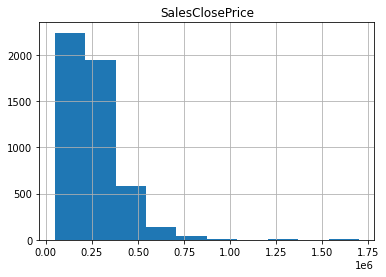

In [ ]:
real_estate_df.select('SalesClosePrice').toPandas().hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f569cfe3990>]],
      dtype=object)

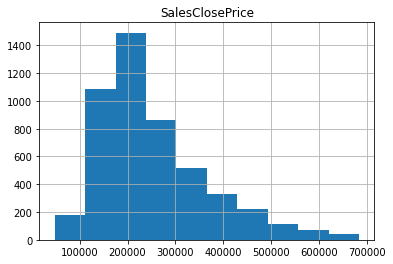

In [ ]:
real_estate_df_filtered.select('SalesClosePrice').toPandas().hist()

A good data scientist will always be inquisitive to see if there is a better way to do things, and it is the curse of data science that there most often is!

If we look closely, we have not really changed anything from the lower bound and might have penalised a bit too much on the right. this is because our distribution is right skewed and we tried to filter assuming normal distribution.

Lets us try doing the same in `log` of sales price

In [ ]:
from pyspark.sql.functions import mean, stddev

# calculate log of sales price
real_estate_df_log = real_estate_df.withColumn('log_sales_price',F.log(real_estate_df.SalesClosePrice))

# Calculate values used for outlier filtering
mean_val = real_estate_df_log.agg({'log_sales_price': 'mean'}).collect()[0][0]
stddev_val = real_estate_df_log.agg({'log_sales_price':'stddev'}).collect()[0][0]

# Create three standard deviation (μ ± 3σ) lower and upper bounds for data
low_bound = mean_val - (3 * stddev_val)
hi_bound = mean_val + (3 * stddev_val)

# Filter the data to fit between the lower and upper bounds
real_estate_df_filtered = real_estate_df_log.where((real_estate_df_log['log_sales_price'] < hi_bound) & (real_estate_df_log['log_sales_price'] > low_bound))

# suammry for unfiltered column
real_estate_df_log.describe('SalesClosePrice').show()

real_estate_df_filtered.describe('SalesClosePrice').show()


+-------+------------------+
|summary|   SalesClosePrice|
+-------+------------------+
|  count|              4976|
|   mean|262899.59485530545|
| stddev| 140713.0015588166|
|    min|             48000|
|    max|           1700000|
+-------+------------------+

+-------+------------------+
|summary|   SalesClosePrice|
+-------+------------------+
|  count|              4946|
|   mean| 259043.9393449252|
| stddev|124951.33401444044|
|    min|             61000|
|    max|            920000|
+-------+------------------+



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc960cf9a20>]],
      dtype=object)

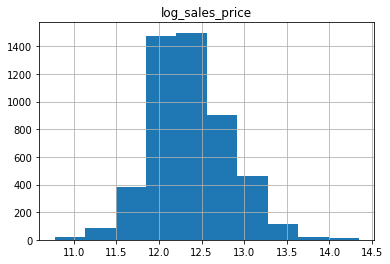

In [ ]:
real_estate_df_log.select('log_sales_price').toPandas().hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc9607367f0>]],
      dtype=object)

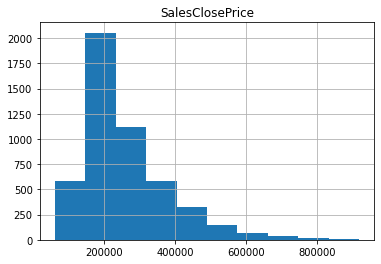

In [ ]:
real_estate_df_filtered.select('SalesClosePrice').toPandas().hist()

What we have done is transforming a right skewed data to a normal like distribution. Such transformations on dependent variables can yeild good results when trying to fit a model.

Now that we are satisfied with our work, lets replace the original dataframe with the new one

In [ ]:
real_estate_df = real_estate_df_filtered
real_estate_df.count()

4897

## Correcting Skewed Data
We have already seen how we can use log transforms to fix positively skewed data. What if we have a negatively skewed data?


In [ ]:
from pyspark.sql.functions import log,skewness
 
# Compute the skewness
print(real_estate_df.agg({'YEARBUILT': 'skewness'}).collect())
print(real_estate_df.agg({'SalesClosePrice': 'skewness'}).collect())

[Row(skewness(YEARBUILT)=-0.2530704729706766)]
[Row(skewness(SalesClosePrice)=1.148636612815356)]


Alhough we may not be able to plot the data using PySpark dataframe yet, `Skewness` method does give a good sense of if our data is skewed.

For this data, lets plot and see it for better visualization

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f569caa6e90>]],
      dtype=object)

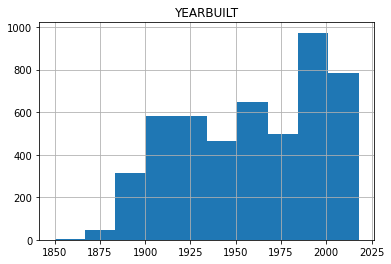

In [ ]:
real_estate_df.select('YEARBUILT').toPandas().hist()

To correct negative skew or left skewed data, we need to take an extra step called "reflecting" before we can perform transformations.

Reflecting data uses the following formula to reflect each value: `(xmax+1)–x`.

What it actually does is reflects a negatively skewed data and makes it positively skewed.

Note: If you have negative values then it is advised to add a constant to make it positive since we will be using logs and square roots for transformation


In [ ]:
# Calculate the max year
max_year = real_estate_df.agg({'YEARBUILT': 'max'}).collect()[0][0]
 
# Create a new column of reflected data
real_estate_df = real_estate_df.withColumn('Reflect_YearBuilt', (max_year + 1) - real_estate_df['YEARBUILT'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f569cae0250>]],
      dtype=object)

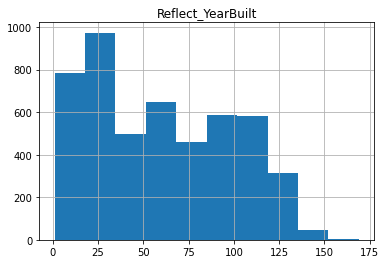

In [ ]:
real_estate_df.select('Reflect_YearBuilt').toPandas().hist()

In [ ]:
# Create a new column based reflected data
real_estate_df = real_estate_df.withColumn('adj_yearbuilt', F.sqrt(real_estate_df['Reflect_YearBuilt']))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f569cb1cdd0>]],
      dtype=object)

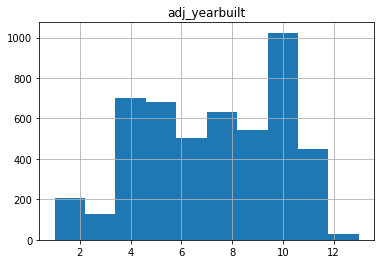

In [ ]:
real_estate_df.select('adj_yearbuilt').toPandas().hist()

## Min-Max Scaling
We will look at one last method to scale our data. These methods can be the *sanjeevani* when trying to build models like regression or logistic.

This is `min-max` scaling were we scale the data between 0 and 1 by simply subtracting the `minimum` value and then divide by `max - min`.

In [ ]:
# Define max and min values and collect them
max_days = real_estate_df.agg({'DAYSONMARKET': 'max'}).collect()[0][0]
min_days = real_estate_df.agg({'DAYSONMARKET': 'min'}).collect()[0][0]

# Create a new column based off the scaled data
real_estate_df = real_estate_df.withColumn('scaled_days', 
                  (real_estate_df['DAYSONMARKET'] - min_days) / (max_days - min_days))

# Calc max and min for new column
print(real_estate_df.agg({'scaled_days': 'max'}).collect())
print(real_estate_df.agg({'scaled_days': 'min'}).collect())


[Row(max(scaled_days)=1.0)]
[Row(min(scaled_days)=0.0)]


## Using Corr()
When we have little knowledge about what to expect from the data and the relation among different features, mathematical or economical, correlation may help in getting to the starting point.

However, it would be incomplete to talk about correlation without the cautionary tale of **'Correlation does not imply Causation'**


In [ ]:
columns =['LISTPRICE', 'OriginalListPrice', 'PricePerTSFT','DAYSONMARKET']

In [ ]:
# Loop to show correlations for all variables
for col in columns:
    corr_val = real_estate_df.corr('SALESCLOSEPRICE', col)
    print("Correlation between SALESCLOSEPRICE and ", col, " is ", corr_val)


Correlation between SALESCLOSEPRICE and  LISTPRICE  is  0.9962732918403051
Correlation between SALESCLOSEPRICE and  OriginalListPrice  is  0.2698586167075354
Correlation between SALESCLOSEPRICE and  PricePerTSFT  is  0.006685740517978635
Correlation between SALESCLOSEPRICE and  DAYSONMARKET  is  0.07970973663364381


# **Plotting data for visualization**
---

In the previous examples, we have used toPandas to convert Spark Dataframe to Pandas dataframe and then used Python's data visualization capabilities.

Another way could be to use `HandySpark` but we are not going to cover that for this session. Below are some useful resources to explore `HandySpark`:

[Github link](https://github.com/dvgodoy/handyspark)

[Colab Notebook with examples](https://colab.research.google.com/github/dvgodoy/handyspark/blob/master/notebooks/Exploring_Titanic.ipynb)


> Tip: create a smaller or aggregated dataset in spark before converting it to Pandas DataFrame

## Using Visualizations: distplot
Understanding the distribution of our dependent variable is very important and can impact the type of model or preprocessing we do. 

A great way to do this is to plot it, however we will sample the original and use Pandas `matplotlib.pyplot` and `seaborn` packages to do this.



/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


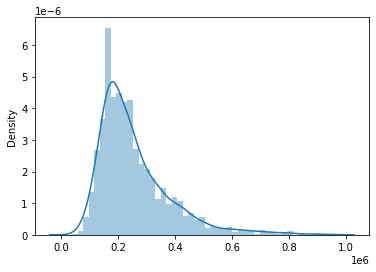

In [ ]:
# Select a single column and sample and convert to pandas
sample_df = real_estate_df.select(['LISTPRICE']).sample(False, 0.5, 100)
pandas_df = sample_df.toPandas()

# Plot distribution of pandas_df and display plot

import seaborn as sns

sns.distplot(pandas_df)
plt.show()


## Using Visualizations: lmplot
Creating linear model plots helps us visualize if variables have relationships with the dependent variable. If they do they are good candidates to include in our analysis. If they don't it doesn't mean that we should throw them out, it means we may have to process them before they can be used.


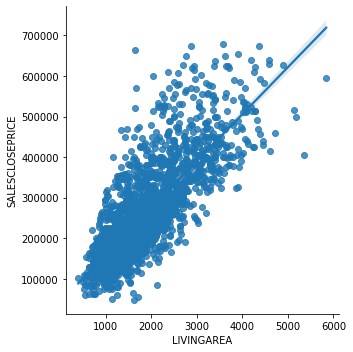

In [ ]:
# Select a the relevant columns and sample
sample_df = real_estate_df.select(['SALESCLOSEPRICE', 'LIVINGAREA']).sample(False, 0.5, 42)

# Convert to pandas dataframe
pandas_df = sample_df.toPandas()

# Linear model plot of pandas_df
sns.lmplot(x='LIVINGAREA', y='SALESCLOSEPRICE', data=pandas_df)
plt.show()


# **Working with Missing Data**
---

## Visualizing Missing Data
Being able to plot missing values is a great way to quickly understand how much of your data is missing. It can also help highlight when variables are missing in a pattern something that will need to be handled with care.


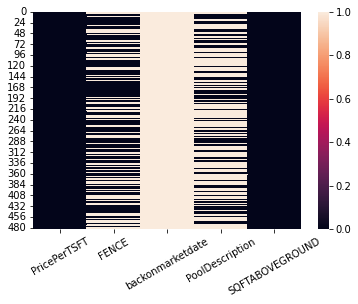

In [ ]:
columns = ['PricePerTSFT','FENCE', 'backonmarketdate', 'PoolDescription','SQFTABOVEGROUND']

# Sample the dataframe and convert to Pandas
sample_df = real_estate_df.select(columns).sample(False, 0.1, 42)
pandas_df = sample_df.toPandas()

# Convert all values to True/False
tf_df = pandas_df.isnull()

import seaborn as sns

# Plot it
sns.heatmap(data=tf_df)
plt.xticks(rotation=30, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.show()


## Imputing Missing Data
Although deleting the columns with lots of missing data might seem to be the reasonable thing to do, sometimes, it can still be used by replacing null values with some reasonable values.

In the above exercise, we saw that `PoolDescription` has lots of missing values, however, after taking to the client we realised that missing values implies the property doesn't have a pool. So we will replace with 'None' for this column.

In [ ]:
# Count missing rows
missing = real_estate_df.where(real_estate_df['PoolDescription'].isNull()).count()
print(missing)

# Replacing with 'None' value for that column
real_estate_df.select('PoolDescription').show(30)
real_estate_df.fillna('None', subset=['PoolDescription']).select('PoolDescription').show(30)


3257
+--------------------+
|     PoolDescription|
+--------------------+
|                null|
|                null|
|                None|
|Below Ground, Out...|
|                null|
|                null|
|                null|
|                null|
|                null|
|Below Ground, Shared|
|                null|
|                null|
|                null|
|                null|
|                null|
|                null|
|                None|
|                null|
|                null|
|                null|
|                null|
|                null|
|                null|
|                null|
|                None|
|Below Ground, Out...|
|                null|
|                null|
|                None|
|                null|
+--------------------+
only showing top 30 rows

+--------------------+
|     PoolDescription|
+--------------------+
|                None|
|                None|
|                None|
|Below Ground, Out...|
|                None|
|  

We can also replace with some calculated values such as mean or median

## Drop columns automatically
Automation is the future of data science and learning to automate some of the data preparation will go a long way. Here we will automate dropping columns if they are missing data beyond a specific threshold.
This can be helpful if we want drop columns based on fill rate.

In [ ]:
def drop_col(df, threshold):
  total_rows = df.count()
  for col in df.columns:
    missing_rows = df.where(df[col].isNull()).count()
    missing_percent = missing_rows / total_rows
    if missing_percent > threshold:
      df = df.drop(col)
  return df

# Drop columns that are more than 80% missing
new_df = drop_col(real_estate_df, 0.8)

print(len(real_estate_df.columns))
print(len(new_df.columns))

73
71


# **Creating New Features**
---

In [ ]:
real_estate_df = spark.read.parquet('/content/drive/My Drive/Colab Datasets/Real_Estate_Data_Parquet')
real_estate_df = real_estate_df.withColumnRenamed('No.','Listing_Numbers')

## Feature generation using differences
Let's explore generating features using existing ones. Here we will calculate the open area around the house and find its correlation with the label column.

In [ ]:
# Lot size in square feet
acres_to_sqfeet = 43560
real_estate_df = real_estate_df.withColumn('LOT_SIZE_SQFT', real_estate_df['ACRES'] * acres_to_sqfeet)

# Create new column garden_size
real_estate_df = real_estate_df.withColumn('garden_size', real_estate_df['LOT_SIZE_SQFT'] - real_estate_df['FOUNDATIONSIZE'])

# Corr of ACRES vs SALESCLOSEPRICE
print("Corr of ACRES vs SALESCLOSEPRICE: " + str(real_estate_df.corr('SALESCLOSEPRICE', 'LOT_SIZE_SQFT')))
# Corr of FOUNDATIONSIZE vs SALESCLOSEPRICE
print("Corr of FOUNDATIONSIZE vs SALESCLOSEPRICE: " + str(real_estate_df.corr('SALESCLOSEPRICE', 'FOUNDATIONSIZE')))
# Corr of garden_size vs SALESCLOSEPRICE
print("Corr of garden_size vs SALESCLOSEPRICE: " + str(real_estate_df.corr('SALESCLOSEPRICE', 'garden_size')))


Corr of ACRES vs SALESCLOSEPRICE: 0.22060612588935305
Corr of FOUNDATIONSIZE vs SALESCLOSEPRICE: 0.6152231695664393
Corr of garden_size vs SALESCLOSEPRICE: 0.2071458543085422


## Creating features using Ratios
Ratios are another commonly used features when building a machine learning models like share of a pariticular product, gender etc.

In [ ]:
# BED_TO_BATHS
real_estate_df = real_estate_df.withColumn('BED_TO_BATHS',real_estate_df.Bedrooms/real_estate_df.BATHSTOTAL)
real_estate_df[['BED_TO_BATHS', 'Bedrooms', 'BATHSTOTAL']].show(5)

# Corr of Bedrooms vs SALESCLOSEPRICE
print("Corr of Bedrooms vs SALESCLOSEPRICE: " + str(real_estate_df.corr('SALESCLOSEPRICE', 'Bedrooms')))
# Corr of BATHSTOTAL vs SALESCLOSEPRICE
print("Corr of BATHSTOTAL vs SALESCLOSEPRICE: " + str(real_estate_df.corr('SALESCLOSEPRICE', 'BATHSTOTAL')))
# Corr of BED_TO_BATHS vs SALESCLOSEPRICE
print("Corr of BED_TO_BATHS vs SALESCLOSEPRICE: " + str(real_estate_df.corr('SALESCLOSEPRICE', 'BED_TO_BATHS')))



+------------+--------+----------+
|BED_TO_BATHS|Bedrooms|BATHSTOTAL|
+------------+--------+----------+
|         2.0|       4|         2|
|         1.0|       1|         1|
|         3.0|       3|         1|
|        1.25|       5|         4|
|         1.5|       3|         2|
+------------+--------+----------+
only showing top 5 rows

Corr of Bedrooms vs SALESCLOSEPRICE: 0.5348605700654692
Corr of BATHSTOTAL vs SALESCLOSEPRICE: 0.6922501532803724
Corr of BED_TO_BATHS vs SALESCLOSEPRICE: -0.2733668713362824


## Deeper Features
Creating more complicated variables doen not necesarily increase efficacy of the features. Lets see an example

+-------+-------------------+
|summary| BATHS_PER_1000SQFT|
+-------+-------------------+
|  count|               5000|
|   mean|  1.430261748373992|
| stddev| 14.128904102459366|
|    min|0.39123630672926446|
|    max|             1000.0|
+-------+-------------------+



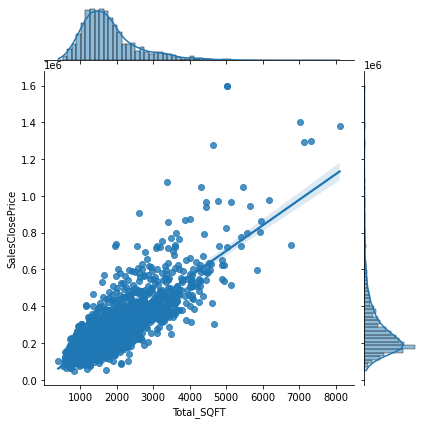

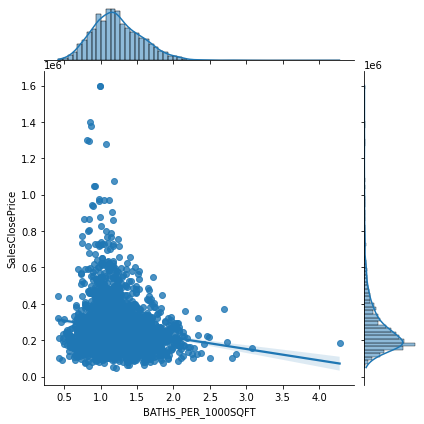

In [ ]:
# Create new feature by adding two features together
real_estate_df = real_estate_df.withColumn('Total_SQFT', real_estate_df['SQFTBELOWGROUND'] + real_estate_df['SQFTABOVEGROUND'])

# Create additional new feature using previously created feature
real_estate_df = real_estate_df.withColumn('BATHS_PER_1000SQFT', real_estate_df['BATHSTOTAL'] / (real_estate_df['Total_SQFT'] / 1000))
real_estate_df[['BATHS_PER_1000SQFT']].describe().show()

# Sample and create pandas dataframe
pandas_df = real_estate_df.sample(False, 0.5, 0).toPandas()

import seaborn as sns

# Linear model plots
sns.jointplot(x='Total_SQFT', y='SalesClosePrice', data=pandas_df, kind="reg")
plt.show()
sns.jointplot(x='BATHS_PER_1000SQFT', y='SalesClosePrice', data=pandas_df, kind="reg")
plt.show()

  ## Extracting Text to New Features
As discussed previously when trying to find 'Dishwasher' in the appliance list, in this exercise we will create a new feature giving information on whether the house has a garage.

In [ ]:
# Import needed functions
from pyspark.sql.functions import when

# Create boolean conditions for string matches
has_attached_garage = real_estate_df['GARAGEDESCRIPTION'].like('%Attached Garage%')
has_detached_garage = real_estate_df['GARAGEDESCRIPTION'].like('%Detached Garage%')

# Conditional value assignment 
df = real_estate_df.withColumn('has_attached_garage', (when(has_attached_garage, 1)
                                          .when(has_detached_garage, 0)
                                          .otherwise(None)))

# Inspect results
df[['GARAGEDESCRIPTION', 'has_attached_garage']].show(10,truncate=100)

+-----------------------------------------------------------------+-------------------+
|                                                GARAGEDESCRIPTION|has_attached_garage|
+-----------------------------------------------------------------+-------------------+
|              Attached Garage, Heated Garage, Driveway - Concrete|                  1|
|                                                   Uncovered/Open|               null|
|         Detached Garage, Driveway - Concrete, Garage Door Opener|                  0|
|         Attached Garage, Driveway - Concrete, Garage Door Opener|                  1|
|                                                  Attached Garage|                  1|
|                                                  Attached Garage|                  1|
|         Detached Garage, Driveway - Concrete, Garage Door Opener|                  0|
|                   Attached Garage, Tuckunder, Driveway - Asphalt|                  1|
|Detached Garage, Driveway - Asp